# Introduction to Interprenet

Interprenet builds constrained neural networks. We currently support monotonic and lipschitz constraints. In this tutorial, we will show how to apply intperpretable constraints to a model trained on the Boston house price dataset.

In [1]:
import pandas
from sklearn.datasets import load_boston

bunch = load_boston()
X = pandas.DataFrame(bunch['data'], columns=bunch['feature_names'])
y = bunch['target']
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


We can get a quick ballpark of which variables exhibit monotonic relations with the target using correlation.

In [2]:
import numpy

correlations = dict(map(reversed,
         sorted(((numpy.corrcoef(X[column], y)[0, 1], column) for column in X.columns),
                key=lambda x: -abs(x[0]))))
correlations

{'LSTAT': -0.7376627261740148,
 'RM': 0.695359947071539,
 'PTRATIO': -0.5077866855375615,
 'INDUS': -0.4837251600283728,
 'TAX': -0.46853593356776696,
 'NOX': -0.4273207723732824,
 'CRIM': -0.3883046085868114,
 'RAD': -0.38162623063977746,
 'AGE': -0.37695456500459606,
 'ZN': 0.3604453424505433,
 'B': 0.33346081965706637,
 'DIS': 0.24992873408590388,
 'CHAS': 0.17526017719029818}

See https://scikit-learn.org/stable/datasets/toy_dataset.html#boston-dataset for details on the meaning of each column.

Comparing correlation to common sense, it seems the following variables do and should exhibit monotonic relations with the target:

* LSTAT % lower status of the population
* RM average number of rooms per dwelling
* CRIM per capita crime rate by town
* CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)

Futhermore, let's assume it would be unreasonable to expect the rate of change of price with respect to any of the above variables except CHAS and RM (which are not continuous) to be no greater than twice the correlation.

In [3]:
import jax

from mvtk import interprenet

constraints = {
    'CRIM': frozenset([interprenet.monotonic_constraint, interprenet.lipschitz_constraint]),
    'ZN': frozenset(),
    'INDUS': frozenset(),
    'CHAS': frozenset([interprenet.monotonic_constraint]),
    'NOX': frozenset([interprenet.monotonic_constraint, interprenet.lipschitz_constraint]),
    'RM':frozenset([interprenet.monotonic_constraint]),
    'AGE': frozenset(),
    'DIS': frozenset(),
    'RAD': frozenset(),
    'TAX': frozenset(),
    'PTRATIO': frozenset(),
    'B': frozenset(),
    'LSTAT': frozenset([interprenet.monotonic_constraint, interprenet.lipschitz_constraint])}

def get_scale(column):
    scale = 1
    if interprenet.monotonic_constraint in constraints[column]:
        # monotonic decreasing features need their sign flipped
        # before entering the neural network
        scale *= numpy.sign(correlations[column])
    if interprenet.lipschitz_constraint in constraints[column]:
        # rescale before applying lipschitz constraint
        # to match assumptions mentioned in the previous block
        scale *= 2 * abs(correlations[column])
    return scale

rescale = lambda x: x * numpy.asarray(list(map(get_scale, X.columns)))
init_params, model = interprenet.constrained_model(
    tuple(constraints[column] for column in X.columns),
    preprocess=rescale,
    postprocess=jax.nn.relu) # monotonicity and lipschitz preserving way of eliminating negative prices

In [4]:
import jax
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(jax.numpy.asarray(X.values),
                                                    jax.numpy.asarray(y.astype('float')),
                                                    test_size=0.2,
                                                    random_state=0)

In [5]:
def mean_absolute_percentage_error(y, y_pred):
    return (abs(y - y_pred) / y).mean()

trained_params = interprenet.train((X_train, y_train),
                                   (X_test, y_test),
                                   (init_params, model),
                                   metric=lambda y, y_pred: -mean_absolute_percentage_error(y, y_pred),
                                   loss_fn=mean_absolute_percentage_error,
                                   num_epochs=32)

In [6]:
trained_model = lambda X: model(trained_params, X)
mean_absolute_percentage_error(y_test, trained_model(X_test))

DeviceArray(0.306767, dtype=float32)

No matter what the values of the other features are (blue lines) increasing CRIM always decreases price, but at a maximum rate.

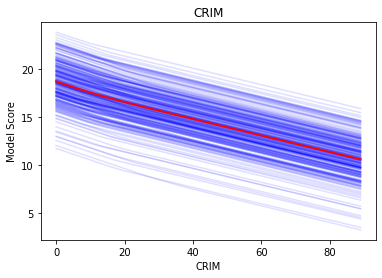

In [7]:
import matplotlib.pylab as plt

interprenet.plot(trained_model, X, 'CRIM')
plt.show()

No matter what the values of the other features are (blue lines) increasing LSTAT always decreases price, but at a maximum rate.

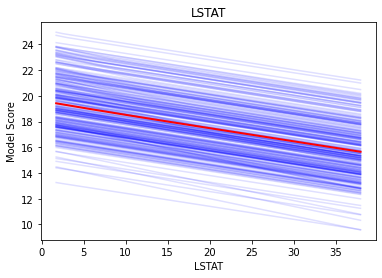

In [8]:
import matplotlib.pylab as plt

interprenet.plot(trained_model, X, 'LSTAT')
plt.show()

AGE can increase or decrease the price of the house at unbounded rates.

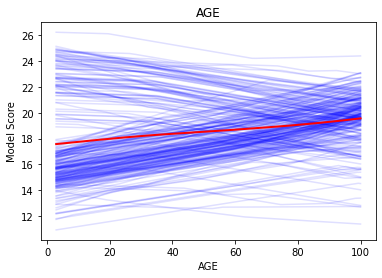

In [9]:
import matplotlib.pylab as plt

interprenet.plot(trained_model, X, 'AGE')
plt.show()

RM can only increase the price of the house.

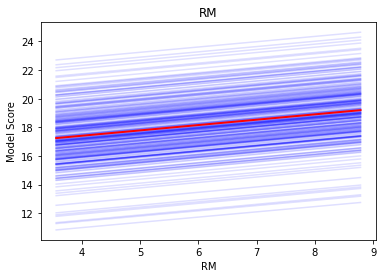

In [10]:
import matplotlib.pylab as plt

interprenet.plot(trained_model, X, 'RM')
plt.show()